<a href="https://colab.research.google.com/github/audrb1999/Python_image/blob/main/git_hub12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***13. 중급 Captcha Hacking ③ - 데이터 정제***

머신러닝을 사용할려면 이미지를 그대로 사용할 순 없고 사용할 수 있는 형태로 정제해야함!

mnist 인식을 할 때 flatten을 해서 쓴 것 처럼 이런 것들을 정제라고함!

1. 색상 별로 이미지를 추출하는 utils.py를 알아보자

In [ ]:
BLUE = 0# bgr 순서
GREEN = 1
RED = 2

# 특정한 색상의 모든 단어가 포함된 이미지를 추출합니다.
# 어떠한 색상이 들어왔다하면
# blue(0)가 들어왔다하면 그것과 다른 두 가지 색을 고름
def get_chars(image, color):
    other1 = (color + 1) % 3# 이것을 통해 다른 두 가지를 고름 Green
    other2 = (color + 2) % 3# red

    c = image[:, :, other1] == 255# (FF) = 255 다른 색깔들은 제거 순수 green 제거
    image[c] = [0, 0, 0]# 000으로 만듬
    
    c = image[:, :, other2] == 255# 순수 red 제거
    image[c] = [0, 0, 0]
    
#그리고 색깔 두 개가 겹치는 곳을 따로 제거해줌
    c = image[:, :, color] < 170# 파란색 값이 부족하면 없앰 파란색과 섞이면 괜찮지만 red green이 섞인 것들은 제거
    image[c] = [0, 0, 0]

    c = image[:, :, color] != 0# 파란색이 0이 아닌것들은 흰색으로 바꿈
    image[c] = [255, 255, 255]

    return image

그 다음 이 파일을 실행시킬 코드를 만들어보자!


In [ ]:
import cv2
import utils

image = cv2.imread('1.png', cv2.IMREAD_COLOR)
blue = utils.get_chars(image.copy(), utils.BLUE)
green = utils.get_chars(image.copy(), utils.GREEN)
red = utils.get_chars(image.copy(), utils.RED)

cv2.imshow('Image Gray', blue)
cv2.waitKey(0)

cv2.imshow('Image Gray', green)
cv2.waitKey(0)

cv2.imshow('Image Gray', red)
cv2.waitKey(0)

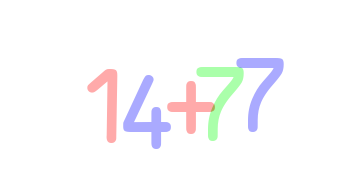

이 파일을 돌리면 첫 번째로 파란색 부분

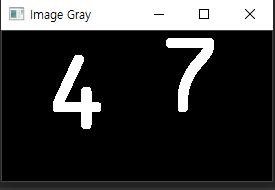

두 번째로 초록색 부분

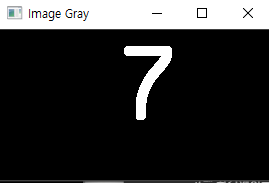


세 번째로 빨간색 부분 이렇게 나옵니다.

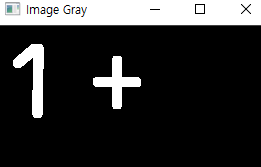

## ***수식을 계산하기 위한 준비***

##***트레이닝 데이터 만들기***

> 이미지를 (20x20)크기로 통일!

In [1]:
def extract_chars(image):
    chars = []
    colors = [BLUE, GREEN, RED]# 색깔별로 모든 이미지를 추출할 수 있게함!
    for color in colors:
        image_from_one_color = get_chars(image.copy(), color)# 색상별로 숫자 이미지 추출 추출된 넘파이 객체 저장
        image_gray = cv2.cvtColor(image_from_one_color, cv2.COLOR_BGR2GRAY)#그레이로 적용
        ret, thresh = cv2.threshold(image_gray, 127, 255, 0)# 그 다음 threshold로 바이너리 처리 > 컨투어를 쓰기위한 준비
        # RETR_EXTERNA; 옵션으로 숫자의 외각을 기준으로 분리
        contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

        for contour in contours:# 추출 후 약간 의미없는 하얀 픽셀들이 생기는데 그걸 제거
            # 추출된 이미지 크기가 50이상인 경우만 실제 문자 데이터인 것으로 파악 작은 픽셀 지우기
            area = cv2.contourArea(contour)#픽셀 크기 측정
            if area > 50:
                x, y, w, h = cv2.boundingRect(contour)
                roi = image_gray[y:y + h, x:x + w]#숫자에 해당하는 부분만 뽑기 위해서 roi를 이용!
                chars.append((x, roi))

    chars = sorted(chars, key = lambda char:char[0])# 추출 이미지를 x축으로 정렬
    return chars


In [ ]:
# 특정 이미지를 (20x20)크기로 Scaling 합니다.
def resize20(image):
    resized = cv2.resize(image, (20, 20))
    return resized.reshape(-1, 400).astype(np.float32)

***실제 트레이닝 데이터 만들기***

> imwrite 경로에서 스페이스바가 들어가면 오류는 안나는데 저장이 안됨!

> 직접 저 경로에 알맞은 폴더들을 만들고! 해야함!



In [ ]:
import os
import cv2
import utils
#training_data 폴더 생성 및 그 내부에 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 폴더 생성

image = cv2.imread('4.png')
chars = utils.extract_chars(image)# 색깔별 숫자 추출


for char in chars:
    cv2.imshow('Image', char[1])# 이미지 보여주고
    input = cv2.waitKey(0)
    resized = cv2.resize(char[1], (20, 20))# 크기 변경

# 사용자의 입력으로 라벨링함!
    if input >= 48 and input <=57:
        name = str(input - 48)
        file_count = len(os.listdir('./training_data/' + name + '/'))# 파일 이름이 안 겹치게 만드는 것 1 2 3 4 이렇게
        #사용자가 만들어준 디렉토리로 해당 데이터가 이동
        #확장자 지정 꼭 하자!
        cv2.imwrite('./training_data/' + str(input - 48) + '/' + str(file_count + 1) + '.png', resized)
        print('./training_data/' + str(input - 48) + '/' + str(file_count + 1) + '.png')

    elif input == ord('a') or input == ord('b') or input == ord('c'):#+ - * 경우는 (+,a), (-, b), (*, c)로 구분해서 만듬
        name = str(input - ord('a') + 10)
        file_count = len(os.listdir('./training_data/' + name + '/'))
        cv2.imwrite('./training_data/' + name + '/'+ str(file_count + 1) + '.png', resized)

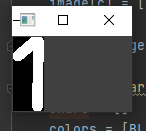

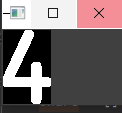

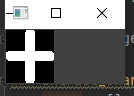

이렇게 하나씩 뜨면 알맞은 숫자를 적으면 됩니다!

사람이 직접 레이블링하는 것!

위에 폴더 사진에 다 들어가 있는 모습

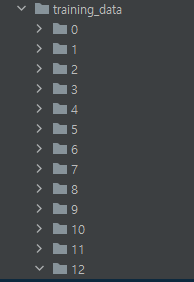